# Feature Importance Analysis for Valence and Arousal Prediction

This notebook analyzes which EEG features (channel-band combinations) have the most impact on predicting valence and arousal.

## Methods Used:
1. **Correlation Analysis** - Direct correlation between features and targets
2. **Random Forest Feature Importance** - Tree-based importance scores
3. **Permutation Importance** - Model-agnostic importance
4. **Statistical Tests** - F-statistic and Mutual Information
5. **Linear Model Coefficients** - SVM weight analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import f_classif, mutual_info_classif
from scipy.stats import spearmanr, pearsonr

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

# ============================================================================
# CONFIGURATION: Adjust these parameters as needed
# ============================================================================
TOP_N_FEATURES = 30  # Number of top features to display in outputs and plots
TOP_N_VISUALIZE = 20  # Number of features to show in visualization plots
TOP_N_AGGREGATE = 50  # Number of features in final aggregated ranking
# ============================================================================

print(f"Configuration:")
print(f"  - Top N features for output tables: {TOP_N_FEATURES}")
print(f"  - Top N features for visualizations: {TOP_N_VISUALIZE}")
print(f"  - Top N features for final ranking: {TOP_N_AGGREGATE}")

Configuration:
  - Top N features for output tables: 30
  - Top N features for visualizations: 20
  - Top N features for final ranking: 50


## 1. Load Data

In [3]:
# Define paths
base_path = Path('../datasets/DEAP/deap-dataset')
features_path = base_path / 'extracted_features'
labels_path = base_path / 'Metadata/participant_ratings.xls'

# Channel names (32 EEG channels)
channels = [
    'Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1',
    'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8',
    'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2'
]

# Frequency bands
bands = ['alpha', 'beta', 'gamma']

# Load labels
labels_df = pd.read_excel(labels_path)

# Binarize valence and arousal (threshold 4.5)
y_valence = (labels_df['Valence'] > 4.5).astype(int).values
y_arousal = (labels_df['Arousal'] > 4.5).astype(int).values

print(f"Labels shape: {labels_df.shape}")
print(f"Valence distribution: {np.bincount(y_valence)}")
print(f"Arousal distribution: {np.bincount(y_arousal)}")

Labels shape: (1280, 9)
Valence distribution: [472 808]
Arousal distribution: [464 816]


In [4]:
# Load and concatenate features from all channels
X_list = []
feature_names = []

for channel in channels:
    channel_data = []
    
    for subject in range(1, 33):  # 32 subjects
        file_path = features_path / channel / f's{subject:02d}_bandpower.csv'
        df = pd.read_csv(file_path)
        channel_data.append(df[['alpha_power', 'beta_power', 'gamma_power']].values)
    
    # Stack all subjects (1280 trials total)
    channel_features = np.vstack(channel_data)
    X_list.append(channel_features)
    
    # Create feature names
    for band in bands:
        feature_names.append(f'{channel}_{band}')

# Concatenate all channels horizontally (1280 samples × 96 features)
X = np.hstack(X_list)

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"First 5 feature names: {feature_names[:5]}")

Feature matrix shape: (1280, 96)
Number of features: 96
First 5 feature names: ['Fp1_alpha', 'Fp1_beta', 'Fp1_gamma', 'AF3_alpha', 'AF3_beta']


In [5]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create DataFrame for easier analysis
X_df = pd.DataFrame(X_scaled, columns=feature_names)
X_df['valence'] = y_valence
X_df['arousal'] = y_arousal

print("Data loaded and normalized successfully!")

Data loaded and normalized successfully!


## 2. Correlation Analysis

In [6]:
# Calculate correlation for each feature with valence and arousal
correlations = pd.DataFrame({
    'Feature': feature_names,
    'Valence_Pearson': [pearsonr(X_scaled[:, i], y_valence)[0] for i in range(len(feature_names))],
    'Arousal_Pearson': [pearsonr(X_scaled[:, i], y_arousal)[0] for i in range(len(feature_names))],
    'Valence_Spearman': [spearmanr(X_scaled[:, i], y_valence)[0] for i in range(len(feature_names))],
    'Arousal_Spearman': [spearmanr(X_scaled[:, i], y_arousal)[0] for i in range(len(feature_names))]
})

# Add absolute values for ranking
correlations['Valence_Abs'] = correlations['Valence_Pearson'].abs()
correlations['Arousal_Abs'] = correlations['Arousal_Pearson'].abs()

# Sort by absolute correlation
valence_top_corr = correlations.nlargest(TOP_N_FEATURES, 'Valence_Abs')
arousal_top_corr = correlations.nlargest(TOP_N_FEATURES, 'Arousal_Abs')

print(f"\n=== Top {TOP_N_FEATURES} Features by Correlation with VALENCE ===")
print(valence_top_corr[['Feature', 'Valence_Pearson', 'Valence_Spearman']].to_string(index=False))

print(f"\n=== Top {TOP_N_FEATURES} Features by Correlation with AROUSAL ===")
print(arousal_top_corr[['Feature', 'Arousal_Pearson', 'Arousal_Spearman']].to_string(index=False))


=== Top 30 Features by Correlation with VALENCE ===
  Feature  Valence_Pearson  Valence_Spearman
AF4_alpha        -0.099796         -0.083325
 AF4_beta        -0.095931         -0.082020
 Fp1_beta        -0.085755         -0.041948
Fp1_alpha        -0.083708         -0.040541
CP1_alpha        -0.079863         -0.063693
 CP1_beta        -0.078049         -0.054669
FC6_alpha        -0.077048         -0.048639
 FC6_beta        -0.076596         -0.038560
FC6_gamma        -0.075903         -0.035155
Fp1_gamma        -0.074946         -0.064815
Fp2_alpha        -0.074877         -0.039257
 Oz_alpha        -0.068323         -0.084574
 C3_alpha        -0.066775         -0.035628
AF4_gamma        -0.066215         -0.092787
 C3_gamma        -0.064679         -0.027521
 P4_alpha        -0.064667         -0.078571
 Fp2_beta        -0.063910         -0.051922
CP1_gamma        -0.061614         -0.042627
  C3_beta        -0.060723         -0.026824
 F4_gamma        -0.057002         -0.017393
 F

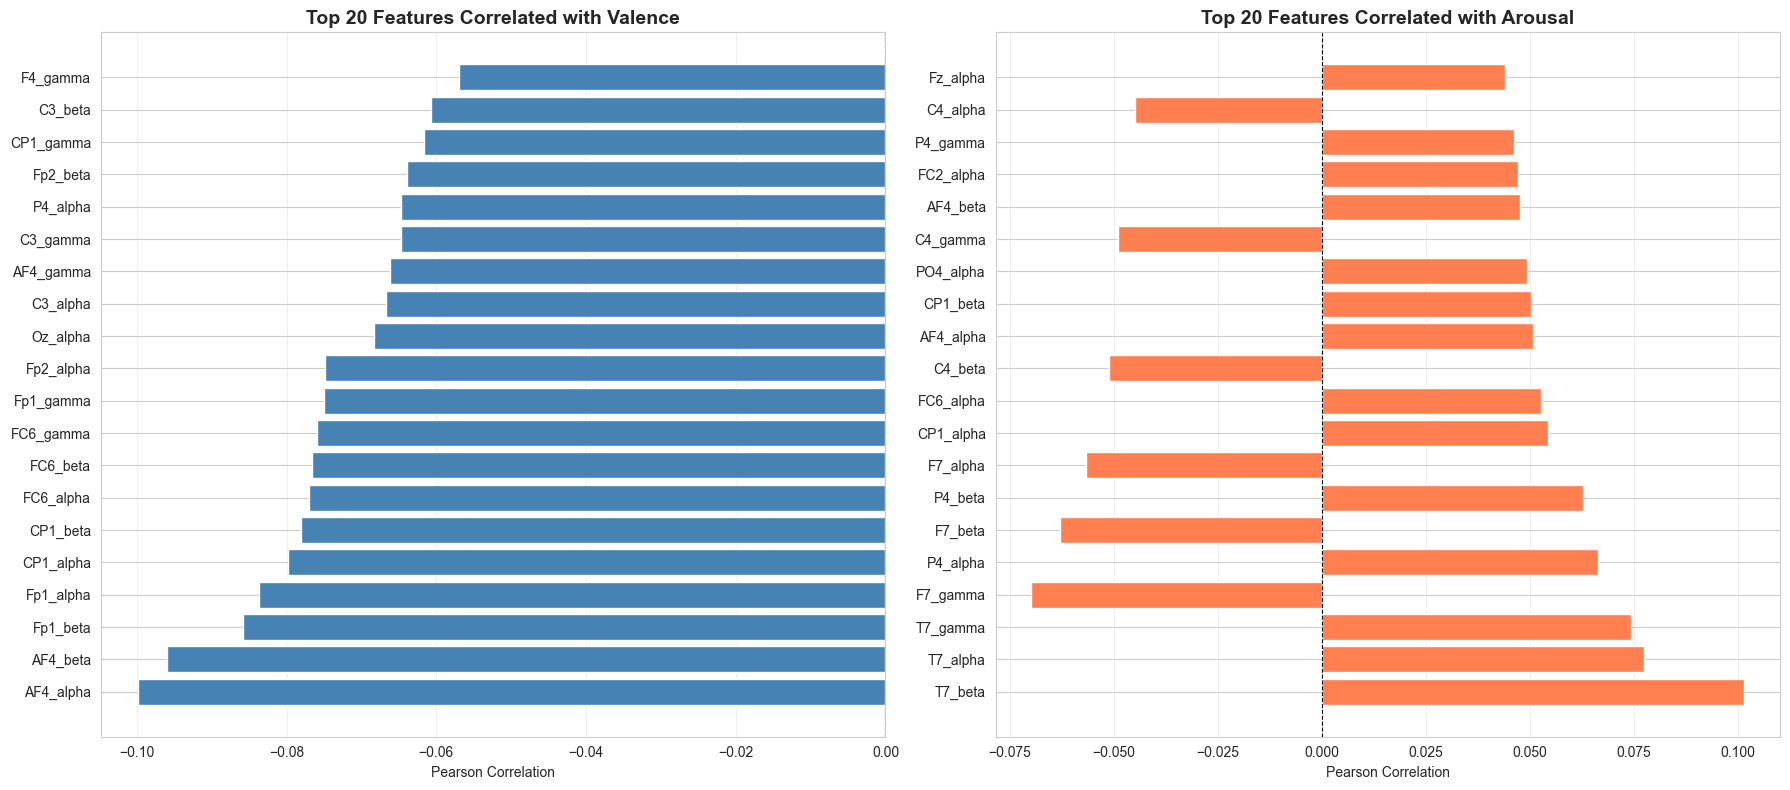

In [7]:
# Visualize top correlations
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Valence
top_val = valence_top_corr.nlargest(TOP_N_VISUALIZE, 'Valence_Abs')
axes[0].barh(range(len(top_val)), top_val['Valence_Pearson'].values, color='steelblue')
axes[0].set_yticks(range(len(top_val)))
axes[0].set_yticklabels(top_val['Feature'].values)
axes[0].set_xlabel('Pearson Correlation')
axes[0].set_title(f'Top {TOP_N_VISUALIZE} Features Correlated with Valence', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].grid(axis='x', alpha=0.3)

# Arousal
top_aro = arousal_top_corr.nlargest(TOP_N_VISUALIZE, 'Arousal_Abs')
axes[1].barh(range(len(top_aro)), top_aro['Arousal_Pearson'].values, color='coral')
axes[1].set_yticks(range(len(top_aro)))
axes[1].set_yticklabels(top_aro['Feature'].values)
axes[1].set_xlabel('Pearson Correlation')
axes[1].set_title(f'Top {TOP_N_VISUALIZE} Features Correlated with Arousal', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Statistical Significance Tests

In [8]:
# ANOVA F-test
f_scores_val, p_values_val = f_classif(X_scaled, y_valence)
f_scores_aro, p_values_aro = f_classif(X_scaled, y_arousal)

# Mutual Information
mi_scores_val = mutual_info_classif(X_scaled, y_valence, random_state=42)
mi_scores_aro = mutual_info_classif(X_scaled, y_arousal, random_state=42)

# Create DataFrame
statistical_scores = pd.DataFrame({
    'Feature': feature_names,
    'F_Score_Valence': f_scores_val,
    'P_Value_Valence': p_values_val,
    'MI_Score_Valence': mi_scores_val,
    'F_Score_Arousal': f_scores_aro,
    'P_Value_Arousal': p_values_aro,
    'MI_Score_Arousal': mi_scores_aro
})

# Sort by F-score
valence_top_f = statistical_scores.nlargest(TOP_N_FEATURES, 'F_Score_Valence')
arousal_top_f = statistical_scores.nlargest(TOP_N_FEATURES, 'F_Score_Arousal')

print(f"\n=== Top {TOP_N_FEATURES} Features by F-Score (VALENCE) ===")
print(valence_top_f[['Feature', 'F_Score_Valence', 'P_Value_Valence', 'MI_Score_Valence']].to_string(index=False))

print(f"\n=== Top {TOP_N_FEATURES} Features by F-Score (AROUSAL) ===")
print(arousal_top_f[['Feature', 'F_Score_Arousal', 'P_Value_Arousal', 'MI_Score_Arousal']].to_string(index=False))


=== Top 30 Features by F-Score (VALENCE) ===
  Feature  F_Score_Valence  P_Value_Valence  MI_Score_Valence
AF4_alpha        12.855905         0.000349          0.004334
 AF4_beta        11.870271         0.000589          0.015114
 Fp1_beta         9.468033         0.002135          0.013607
Fp1_alpha         9.018117         0.002725          0.000000
CP1_alpha         8.203522         0.004249          0.008508
 CP1_beta         7.832815         0.005208          0.023898
FC6_alpha         7.632088         0.005816          0.000000
 FC6_beta         7.542239         0.006111          0.007248
FC6_gamma         7.405478         0.006591          0.000000
Fp1_gamma         7.219018         0.007307          0.002137
Fp2_alpha         7.205604         0.007362          0.004930
 Oz_alpha         5.993675         0.014491          0.000000
 C3_alpha         5.724067         0.016878          0.001503
AF4_gamma         5.627933         0.017824          0.026916
 C3_gamma         5.3688

## 4. Random Forest Feature Importance

In [9]:
# Train Random Forest for Valence
rf_val = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_val.fit(X_scaled, y_valence)

# Train Random Forest for Arousal
rf_aro = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_aro.fit(X_scaled, y_arousal)

# Get feature importances
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Valence_Importance': rf_val.feature_importances_,
    'Arousal_Importance': rf_aro.feature_importances_
})

# Sort by importance
valence_top_rf = rf_importance.nlargest(TOP_N_FEATURES, 'Valence_Importance')
arousal_top_rf = rf_importance.nlargest(TOP_N_FEATURES, 'Arousal_Importance')

print(f"\n=== Top {TOP_N_FEATURES} Features by Random Forest Importance (VALENCE) ===")
print(valence_top_rf.to_string(index=False))

print(f"\n=== Top {TOP_N_FEATURES} Features by Random Forest Importance (AROUSAL) ===")
print(arousal_top_rf.to_string(index=False))


=== Top 30 Features by Random Forest Importance (VALENCE) ===
  Feature  Valence_Importance  Arousal_Importance
FC1_gamma            0.020147            0.011457
Fp1_gamma            0.016266            0.013729
AF4_gamma            0.014874            0.009281
 T7_gamma            0.014253            0.013782
 P8_gamma            0.014178            0.010453
FC5_gamma            0.013514            0.011722
 PO3_beta            0.013455            0.010262
 O2_gamma            0.013336            0.010174
 FC1_beta            0.013281            0.013762
  O2_beta            0.013115            0.008961
AF4_alpha            0.013037            0.010958
 P4_gamma            0.012875            0.011983
  F4_beta            0.012831            0.009484
FC2_gamma            0.012771            0.014714
 C3_alpha            0.012511            0.009758
  P8_beta            0.012314            0.011060
FC6_gamma            0.011987            0.010253
Fp2_gamma            0.011882        

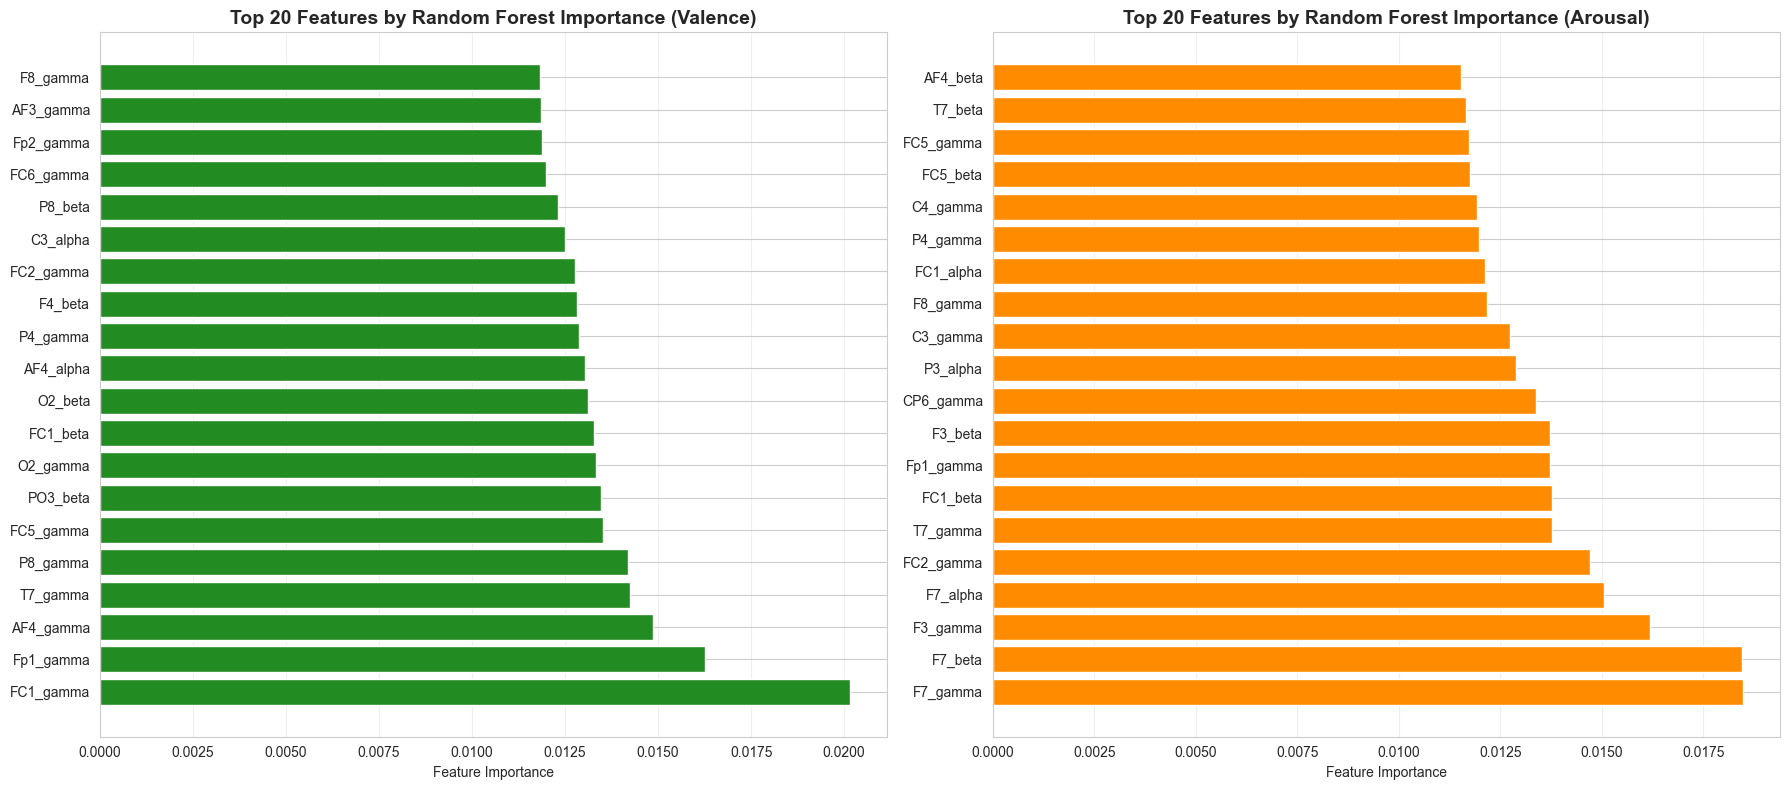

In [10]:
# Visualize Random Forest Importance
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Valence
top_val_rf = valence_top_rf.head(TOP_N_VISUALIZE)
axes[0].barh(range(len(top_val_rf)), top_val_rf['Valence_Importance'].values, color='forestgreen')
axes[0].set_yticks(range(len(top_val_rf)))
axes[0].set_yticklabels(top_val_rf['Feature'].values)
axes[0].set_xlabel('Feature Importance')
axes[0].set_title(f'Top {TOP_N_VISUALIZE} Features by Random Forest Importance (Valence)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Arousal
top_aro_rf = arousal_top_rf.head(TOP_N_VISUALIZE)
axes[1].barh(range(len(top_aro_rf)), top_aro_rf['Arousal_Importance'].values, color='darkorange')
axes[1].set_yticks(range(len(top_aro_rf)))
axes[1].set_yticklabels(top_aro_rf['Feature'].values)
axes[1].set_xlabel('Feature Importance')
axes[1].set_title(f'Top {TOP_N_VISUALIZE} Features by Random Forest Importance (Arousal)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('random_forest_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Permutation Importance

In [11]:
# Split data for permutation importance
X_train, X_test, y_val_train, y_val_test = train_test_split(
    X_scaled, y_valence, test_size=0.2, random_state=42, stratify=y_valence
)

_, _, y_aro_train, y_aro_test = train_test_split(
    X_scaled, y_arousal, test_size=0.2, random_state=42, stratify=y_arousal
)

# Compute permutation importance for Valence
print("Computing permutation importance for Valence...")
perm_val = permutation_importance(rf_val, X_test, y_val_test, n_repeats=10, random_state=42, n_jobs=-1)

# Compute permutation importance for Arousal
print("Computing permutation importance for Arousal...")
perm_aro = permutation_importance(rf_aro, X_test, y_aro_test, n_repeats=10, random_state=42, n_jobs=-1)

# Create DataFrame
perm_importance = pd.DataFrame({
    'Feature': feature_names,
    'Valence_PermImportance': perm_val.importances_mean,
    'Valence_PermStd': perm_val.importances_std,
    'Arousal_PermImportance': perm_aro.importances_mean,
    'Arousal_PermStd': perm_aro.importances_std
})

# Sort by importance
valence_top_perm = perm_importance.nlargest(20, 'Valence_PermImportance')
arousal_top_perm = perm_importance.nlargest(20, 'Arousal_PermImportance')

print("\n=== Top 20 Features by Permutation Importance (VALENCE) ===")
print(valence_top_perm.to_string(index=False))

print("\n=== Top 20 Features by Permutation Importance (AROUSAL) ===")
print(arousal_top_perm.to_string(index=False))

Computing permutation importance for Valence...
Computing permutation importance for Arousal...

=== Top 20 Features by Permutation Importance (VALENCE) ===
  Feature  Valence_PermImportance  Valence_PermStd  Arousal_PermImportance  Arousal_PermStd
FC2_gamma                0.009375         0.001914               -0.004297         0.003685
 T7_gamma                0.007812         0.003026               -0.005859         0.004003
AF4_gamma                0.007422         0.002734               -0.001563         0.003580
FC1_gamma                0.007031         0.002923                0.004687         0.003405
Fp2_gamma                0.007031         0.002923                0.002344         0.001914
 P8_gamma                0.007031         0.003405                0.004687         0.002923
  Cz_beta                0.006641         0.001790               -0.003125         0.005182
  O2_beta                0.006641         0.002501               -0.000781         0.003827
PO4_gamma      

## 6. Linear SVM Coefficients

In [12]:
# Train Linear SVM for Valence
svm_val = LinearSVC(max_iter=5000, random_state=42)
svm_val.fit(X_scaled, y_valence)

# Train Linear SVM for Arousal
svm_aro = LinearSVC(max_iter=5000, random_state=42)
svm_aro.fit(X_scaled, y_arousal)

# Get coefficients
svm_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Valence_Coef': svm_val.coef_[0],
    'Arousal_Coef': svm_aro.coef_[0]
})

# Add absolute values
svm_coefs['Valence_AbsCoef'] = svm_coefs['Valence_Coef'].abs()
svm_coefs['Arousal_AbsCoef'] = svm_coefs['Arousal_Coef'].abs()

# Sort by absolute coefficient
valence_top_svm = svm_coefs.nlargest(20, 'Valence_AbsCoef')
arousal_top_svm = svm_coefs.nlargest(20, 'Arousal_AbsCoef')

print("\n=== Top 20 Features by SVM Coefficient (VALENCE) ===")
print(valence_top_svm[['Feature', 'Valence_Coef', 'Valence_AbsCoef']].to_string(index=False))

print("\n=== Top 20 Features by SVM Coefficient (AROUSAL) ===")
print(arousal_top_svm[['Feature', 'Arousal_Coef', 'Arousal_AbsCoef']].to_string(index=False))


=== Top 20 Features by SVM Coefficient (VALENCE) ===
  Feature  Valence_Coef  Valence_AbsCoef
  O2_beta      1.243184         1.243184
  C3_beta      1.193763         1.193763
 O1_alpha     -1.064030         1.064030
 C4_alpha     -1.037032         1.037032
  O1_beta     -1.010244         1.010244
 F3_gamma     -0.992906         0.992906
 CP6_beta      0.884125         0.884125
 F3_alpha      0.844133         0.844133
 AF4_beta     -0.829260         0.829260
PO3_gamma      0.820623         0.820623
 O1_gamma      0.759180         0.759180
  T8_beta     -0.733011         0.733011
 CP5_beta      0.715143         0.715143
 Fz_alpha      0.671672         0.671672
CP6_alpha      0.650887         0.650887
 C3_alpha     -0.635592         0.635592
CP5_alpha     -0.625222         0.625222
  P7_beta     -0.617551         0.617551
 T8_alpha     -0.585671         0.585671
 Cz_alpha     -0.579328         0.579328

=== Top 20 Features by SVM Coefficient (AROUSAL) ===
  Feature  Arousal_Coef  Arousa

## 7. Aggregate Rankings Across Methods

In [13]:
# Merge all importance scores
all_scores = correlations[['Feature', 'Valence_Abs', 'Arousal_Abs']].copy()
all_scores = all_scores.merge(statistical_scores[['Feature', 'F_Score_Valence', 'F_Score_Arousal']], on='Feature')
all_scores = all_scores.merge(rf_importance[['Feature', 'Valence_Importance', 'Arousal_Importance']], on='Feature')
all_scores = all_scores.merge(perm_importance[['Feature', 'Valence_PermImportance', 'Arousal_PermImportance']], on='Feature')
all_scores = all_scores.merge(svm_coefs[['Feature', 'Valence_AbsCoef', 'Arousal_AbsCoef']], on='Feature')

# Normalize each score to 0-1 range
from sklearn.preprocessing import MinMaxScaler

scaler_rank = MinMaxScaler()
valence_cols = ['Valence_Abs', 'F_Score_Valence', 'Valence_Importance', 'Valence_PermImportance', 'Valence_AbsCoef']
arousal_cols = ['Arousal_Abs', 'F_Score_Arousal', 'Arousal_Importance', 'Arousal_PermImportance', 'Arousal_AbsCoef']

all_scores[valence_cols] = scaler_rank.fit_transform(all_scores[valence_cols])
all_scores[arousal_cols] = scaler_rank.fit_transform(all_scores[arousal_cols])

# Calculate average score
all_scores['Valence_AvgScore'] = all_scores[valence_cols].mean(axis=1)
all_scores['Arousal_AvgScore'] = all_scores[arousal_cols].mean(axis=1)

# Sort by average score
valence_top_overall = all_scores.nlargest(30, 'Valence_AvgScore')
arousal_top_overall = all_scores.nlargest(30, 'Arousal_AvgScore')

print("\n" + "="*80)
print("=== TOP 30 FEATURES FOR VALENCE (Aggregated Across All Methods) ===")
print("="*80)
print(valence_top_overall[['Feature', 'Valence_AvgScore'] + valence_cols].to_string(index=False))

print("\n" + "="*80)
print("=== TOP 30 FEATURES FOR AROUSAL (Aggregated Across All Methods) ===")
print("="*80)
print(arousal_top_overall[['Feature', 'Arousal_AvgScore'] + arousal_cols].to_string(index=False))


=== TOP 30 FEATURES FOR VALENCE (Aggregated Across All Methods) ===
  Feature  Valence_AvgScore  Valence_Abs  F_Score_Valence  Valence_Importance  Valence_PermImportance  Valence_AbsCoef
 AF4_beta          0.620503     0.961056         0.923330            0.301106                 0.25000         0.667023
AF4_alpha          0.593262     1.000000         1.000000            0.482308                 0.40625         0.077752
AF4_gamma          0.569039     0.661654         0.437754            0.616034                 0.84375         0.286004
  C3_beta          0.543337     0.606318         0.367885            0.375989                 0.40625         0.960244
 C3_alpha          0.538552     0.667303         0.445232            0.443996                 0.62500         0.511228
  O2_beta          0.476611     0.102474         0.011387            0.487946                 0.78125         1.000000
 T7_gamma          0.472280     0.522402         0.273621            0.570829                 0.87

In [14]:
# Save results to CSV
all_scores.sort_values('Valence_AvgScore', ascending=False).to_csv('feature_importance_valence.csv', index=False)
all_scores.sort_values('Arousal_AvgScore', ascending=False).to_csv('feature_importance_arousal.csv', index=False)

print("Results saved to:")
print("  - feature_importance_valence.csv")
print("  - feature_importance_arousal.csv")

Results saved to:
  - feature_importance_valence.csv
  - feature_importance_arousal.csv


## 8. Visualize Top Features

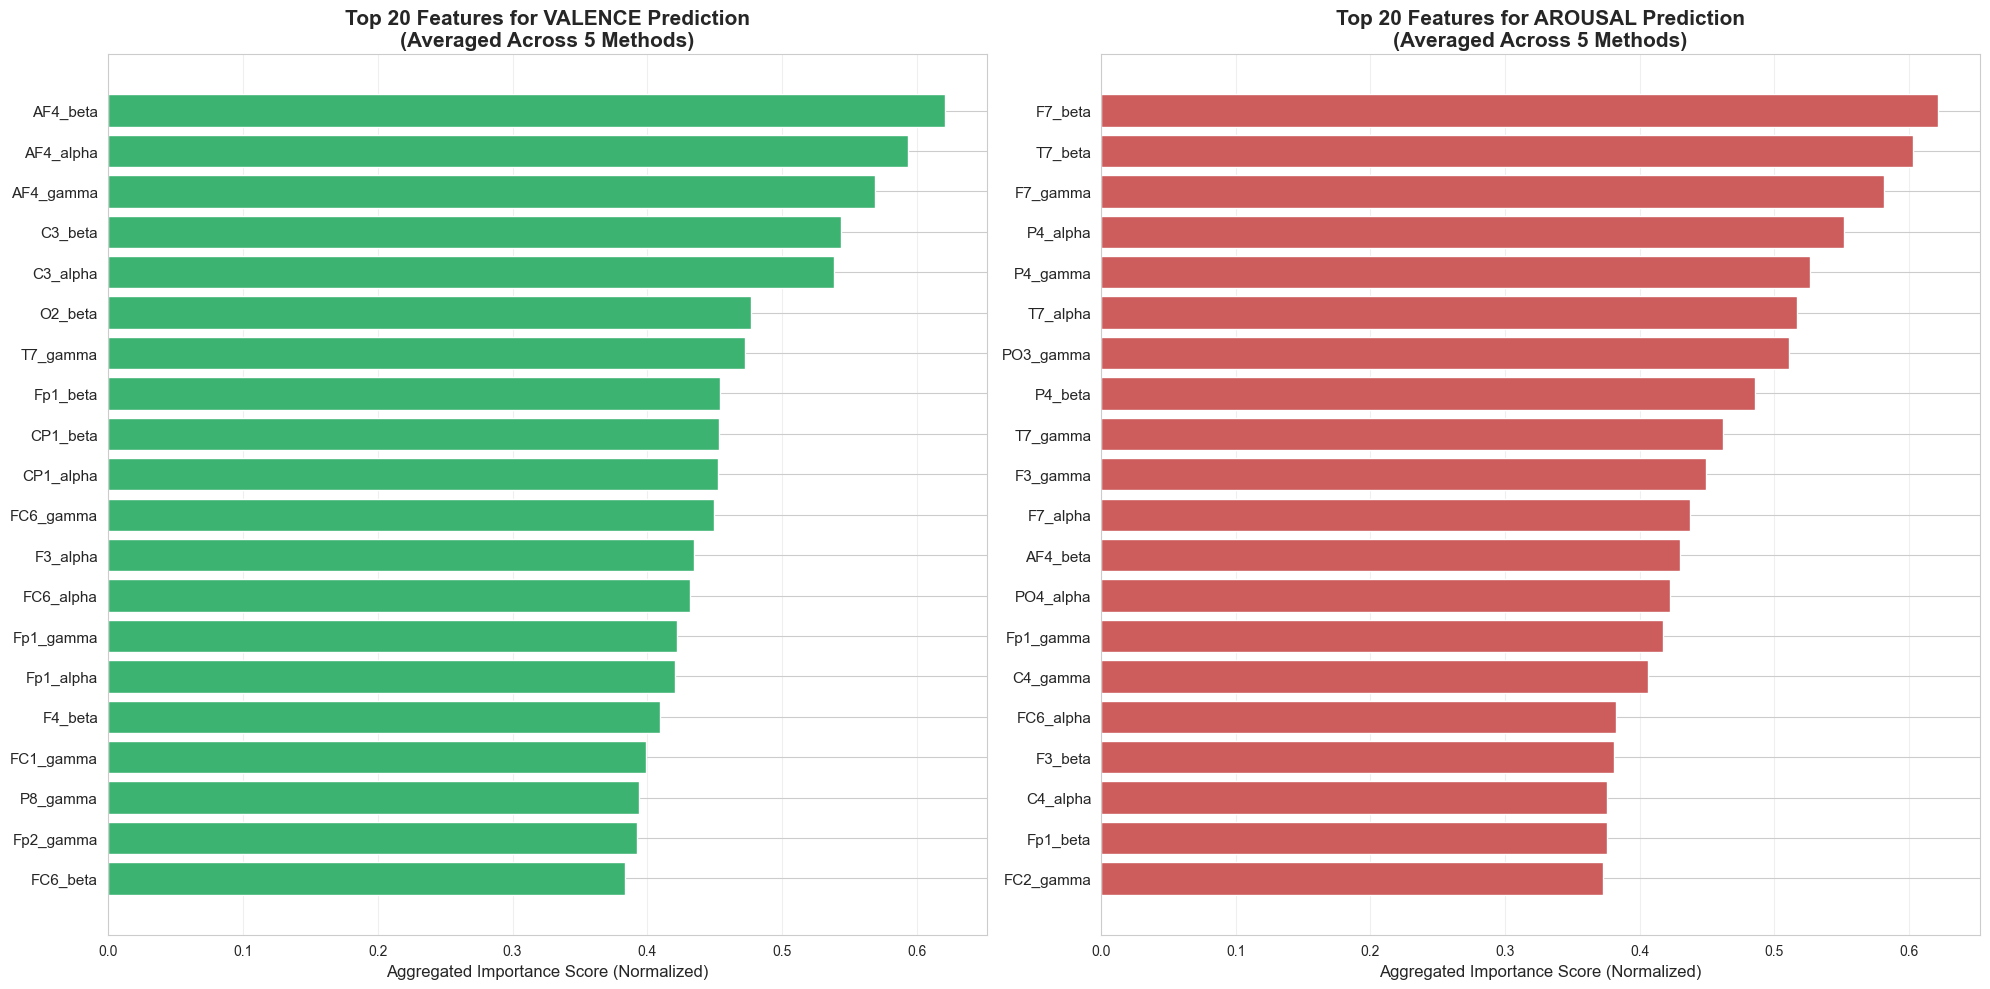

In [15]:
# Plot top features by aggregated score
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Valence
top20_val = valence_top_overall.head(20)
axes[0].barh(range(len(top20_val)), top20_val['Valence_AvgScore'].values, color='mediumseagreen')
axes[0].set_yticks(range(len(top20_val)))
axes[0].set_yticklabels(top20_val['Feature'].values, fontsize=11)
axes[0].set_xlabel('Aggregated Importance Score (Normalized)', fontsize=12)
axes[0].set_title('Top 20 Features for VALENCE Prediction\n(Averaged Across 5 Methods)', 
                  fontsize=15, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Arousal
top20_aro = arousal_top_overall.head(20)
axes[1].barh(range(len(top20_aro)), top20_aro['Arousal_AvgScore'].values, color='indianred')
axes[1].set_yticks(range(len(top20_aro)))
axes[1].set_yticklabels(top20_aro['Feature'].values, fontsize=11)
axes[1].set_xlabel('Aggregated Importance Score (Normalized)', fontsize=12)
axes[1].set_title('Top 20 Features for AROUSAL Prediction\n(Averaged Across 5 Methods)', 
                  fontsize=15, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('top_features_aggregated.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Analysis by Frequency Band

In [16]:
# Extract band from feature name
all_scores['Band'] = all_scores['Feature'].str.split('_').str[-1]
all_scores['Channel'] = all_scores['Feature'].str.rsplit('_', n=1).str[0]

# Group by band
band_importance_val = all_scores.groupby('Band')['Valence_AvgScore'].agg(['mean', 'std', 'count'])
band_importance_aro = all_scores.groupby('Band')['Arousal_AvgScore'].agg(['mean', 'std', 'count'])

print("\n=== Average Importance by Frequency Band (VALENCE) ===")
print(band_importance_val)

print("\n=== Average Importance by Frequency Band (AROUSAL) ===")
print(band_importance_aro)


=== Average Importance by Frequency Band (VALENCE) ===
           mean       std  count
Band                            
alpha  0.286674  0.122787     32
beta   0.288276  0.121853     32
gamma  0.301202  0.099533     32

=== Average Importance by Frequency Band (AROUSAL) ===
           mean       std  count
Band                            
alpha  0.313398  0.087531     32
beta   0.308309  0.111059     32
gamma  0.324211  0.099394     32


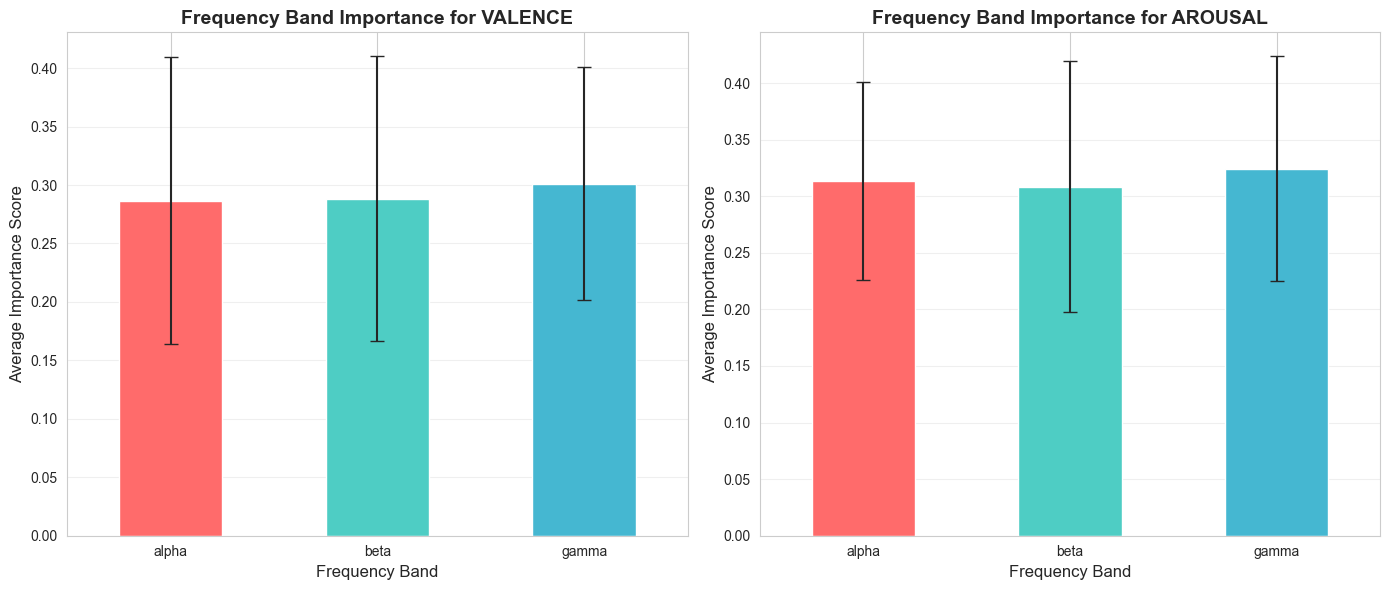

In [17]:
# Plot band importance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Valence
band_importance_val['mean'].plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'], 
                                  yerr=band_importance_val['std'], capsize=5)
axes[0].set_xlabel('Frequency Band', fontsize=12)
axes[0].set_ylabel('Average Importance Score', fontsize=12)
axes[0].set_title('Frequency Band Importance for VALENCE', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Arousal
band_importance_aro['mean'].plot(kind='bar', ax=axes[1], color=['#FF6B6B', '#4ECDC4', '#45B7D1'], 
                                  yerr=band_importance_aro['std'], capsize=5)
axes[1].set_xlabel('Frequency Band', fontsize=12)
axes[1].set_ylabel('Average Importance Score', fontsize=12)
axes[1].set_title('Frequency Band Importance for AROUSAL', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('band_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Brain Region Analysis (Topographic Map)

In [18]:
# Average importance per channel across all bands
channel_importance_val = all_scores.groupby('Channel')['Valence_AvgScore'].mean().sort_values(ascending=False)
channel_importance_aro = all_scores.groupby('Channel')['Arousal_AvgScore'].mean().sort_values(ascending=False)

print("\n=== Top 15 Channels for VALENCE ===")
print(channel_importance_val.head(15))

print("\n=== Top 15 Channels for AROUSAL ===")
print(channel_importance_aro.head(15))


=== Top 15 Channels for VALENCE ===
Channel
AF4    0.594268
C3     0.481544
Fp1    0.431978
FC6    0.421394
CP1    0.415631
Fp2    0.371670
F4     0.368475
F3     0.339423
O2     0.336678
P4     0.323829
T8     0.313563
FC1    0.310171
Oz     0.307686
FC5    0.293332
T7     0.290597
Name: Valence_AvgScore, dtype: float64

=== Top 15 Channels for AROUSAL ===
Channel
F7     0.546809
T7     0.527373
P4     0.521449
F3     0.379580
PO3    0.373439
C4     0.365670
PO4    0.356533
Fp1    0.356210
FC2    0.355541
AF4    0.339141
CP6    0.329424
FC6    0.322078
FC1    0.321830
Fz     0.319060
P8     0.318515
Name: Arousal_AvgScore, dtype: float64


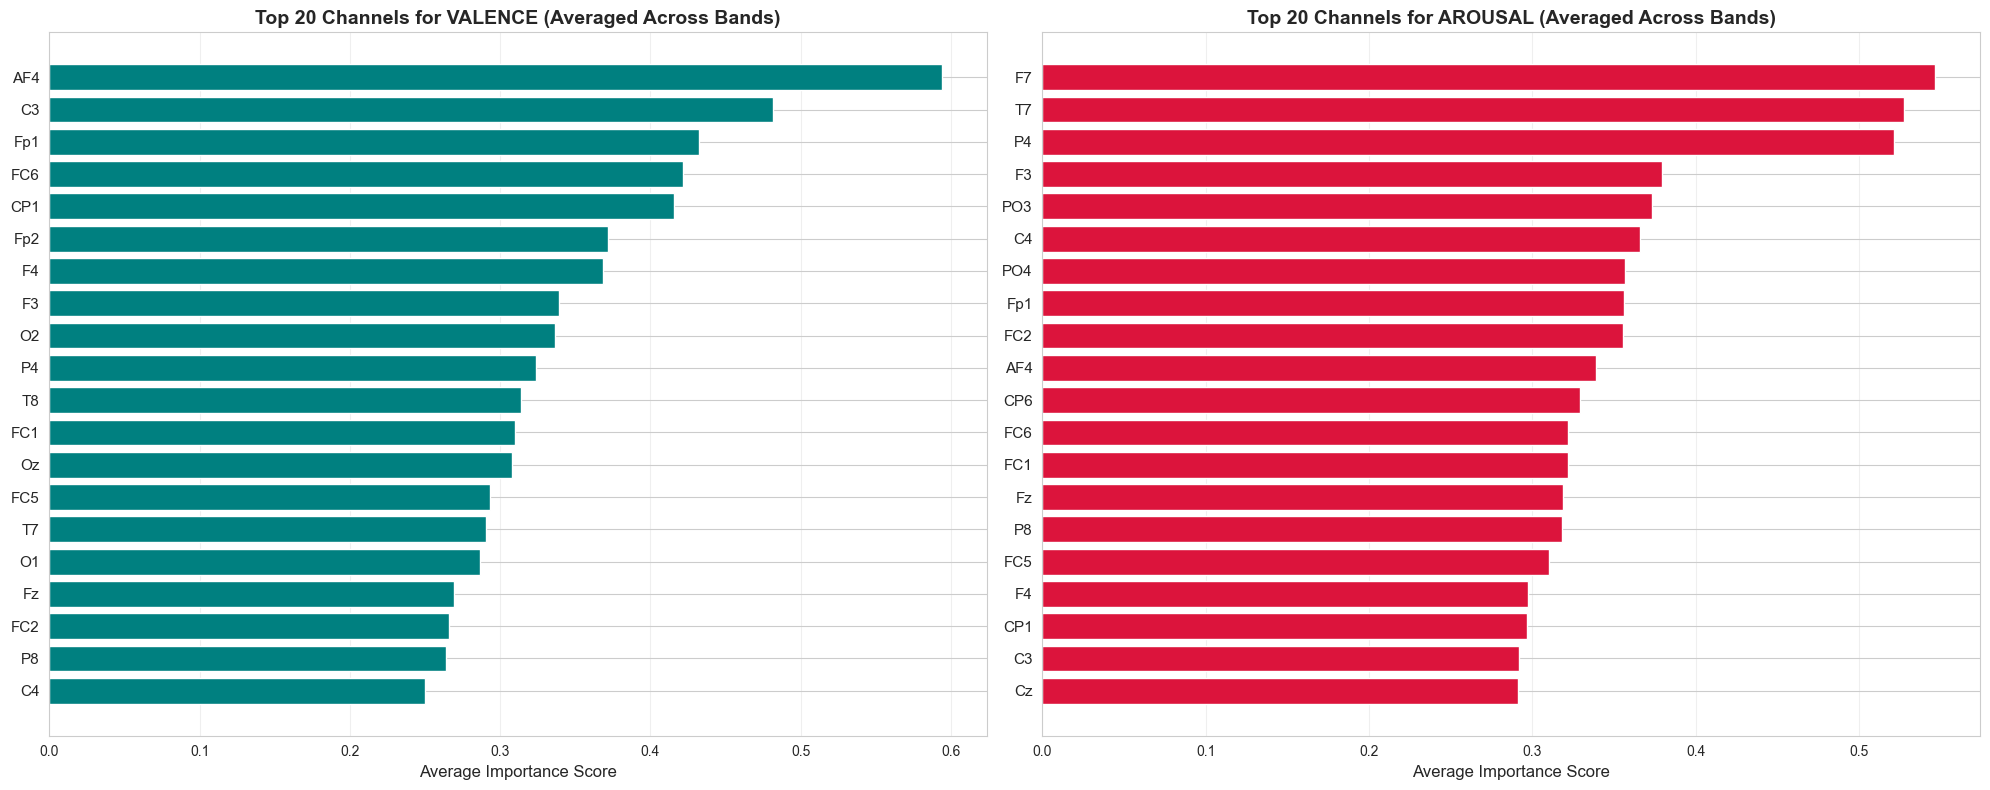

In [19]:
# Visualize channel importance
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Valence
top_channels_val = channel_importance_val.head(20)
axes[0].barh(range(len(top_channels_val)), top_channels_val.values, color='teal')
axes[0].set_yticks(range(len(top_channels_val)))
axes[0].set_yticklabels(top_channels_val.index, fontsize=11)
axes[0].set_xlabel('Average Importance Score', fontsize=12)
axes[0].set_title('Top 20 Channels for VALENCE (Averaged Across Bands)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Arousal
top_channels_aro = channel_importance_aro.head(20)
axes[1].barh(range(len(top_channels_aro)), top_channels_aro.values, color='crimson')
axes[1].set_yticks(range(len(top_channels_aro)))
axes[1].set_yticklabels(top_channels_aro.index, fontsize=11)
axes[1].set_xlabel('Average Importance Score', fontsize=12)
axes[1].set_title('Top 20 Channels for AROUSAL (Averaged Across Bands)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('channel_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Summary Report

In [20]:
print("\n" + "="*100)
print(" "*35 + "FEATURE IMPORTANCE SUMMARY")
print("="*100)

print("\n### VALENCE PREDICTION ###\n")
print("Top 10 Most Important Features:")
for i, row in valence_top_overall.head(10).iterrows():
    print(f"  {row['Feature']:20s} - Score: {row['Valence_AvgScore']:.4f}")

print("\nMost Important Frequency Band:")
best_band_val = band_importance_val['mean'].idxmax()
print(f"  {best_band_val.upper()} (avg score: {band_importance_val.loc[best_band_val, 'mean']:.4f})")

print("\nTop 5 Brain Regions (Channels):")
for i, (channel, score) in enumerate(channel_importance_val.head(5).items(), 1):
    print(f"  {i}. {channel:5s} - Score: {score:.4f}")

print("\n" + "-"*100)

print("\n### AROUSAL PREDICTION ###\n")
print("Top 10 Most Important Features:")
for i, row in arousal_top_overall.head(10).iterrows():
    print(f"  {row['Feature']:20s} - Score: {row['Arousal_AvgScore']:.4f}")

print("\nMost Important Frequency Band:")
best_band_aro = band_importance_aro['mean'].idxmax()
print(f"  {best_band_aro.upper()} (avg score: {band_importance_aro.loc[best_band_aro, 'mean']:.4f})")

print("\nTop 5 Brain Regions (Channels):")
for i, (channel, score) in enumerate(channel_importance_aro.head(5).items(), 1):
    print(f"  {i}. {channel:5s} - Score: {score:.4f}")

print("\n" + "="*100)
print("\nAnalysis complete! Check the generated CSV files and plots for detailed results.")


                                   FEATURE IMPORTANCE SUMMARY

### VALENCE PREDICTION ###

Top 10 Most Important Features:
  AF4_beta             - Score: 0.6205
  AF4_alpha            - Score: 0.5933
  AF4_gamma            - Score: 0.5690
  C3_beta              - Score: 0.5433
  C3_alpha             - Score: 0.5386
  O2_beta              - Score: 0.4766
  T7_gamma             - Score: 0.4723
  Fp1_beta             - Score: 0.4537
  CP1_beta             - Score: 0.4528
  CP1_alpha            - Score: 0.4526

Most Important Frequency Band:
  GAMMA (avg score: 0.3012)

Top 5 Brain Regions (Channels):
  1. AF4   - Score: 0.5943
  2. C3    - Score: 0.4815
  3. Fp1   - Score: 0.4320
  4. FC6   - Score: 0.4214
  5. CP1   - Score: 0.4156

----------------------------------------------------------------------------------------------------

### AROUSAL PREDICTION ###

Top 10 Most Important Features:
  F7_beta              - Score: 0.6217
  T7_beta              - Score: 0.6034
  F7_gamma       